#### **Library imports**

In [1]:
# Library imports
import pyforest
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from tqdm import tqdm
from pprint import pprint
from time import sleep
import time
import seaborn as sns

from turtle import forward
import torch.nn as nn
import torch.nn.functional as F
import math
import torch
from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
from torch.utils.data import DataLoader, TensorDataset

#### **Hyperparams and loading data**

In [3]:
train_edges = np.load('movielens/train_edges.npy')
user_list = train_edges[:, 0]
item_list = train_edges[:, 1]
rating_list = train_edges[:, 2].astype('float32')

n_users = 943 
n_items = 1682
n_samples = len(rating_list)

n_users, n_items, n_samples

(943, 1682, 200000)

#### **Defining collaborative filtering**

In [4]:
class CollaborativeFiltering(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(CollaborativeFiltering, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        dot = (u * i).sum(1)
        return torch.sigmoid(dot)

In [5]:
class NCF(Module):
    def __init__(self, n_users, n_items, n_factors):
        super(NCF, self).__init__()
        self.user_emb = nn.Embedding(n_users, n_factors)
        self.item_emb = nn.Embedding(n_items, n_factors)
        self.fc1 = nn.Linear(n_factors * 2, n_factors)
        self.fc2 = nn.Linear(n_factors, 1)

    def forward(self, user, item):
        tanh = nn.Tanh()
        sigmoid = nn.Sigmoid()

        u = self.user_emb(user)
        i = self.item_emb(item)
        features = torch.concat([u, i], dim = 1)
        x = self.fc1(features)
        x = sigmoid(x)
        x = self.fc2(x)
        x = sigmoid(x)
        return x

In [6]:
def get_accuracy(y_hat, y):
    y = y.clone().int()
    y_hat = (y_hat.clone() > 0.5).int()
    accuracy = (y == y_hat).sum() / len(y)
    return accuracy.item()

#### **Code for surrogate meta-attack**

In [45]:
# start execution
start_time = time.time()

# GPU settings (set use_gpu = -1 if you want to use CPU)
use_gpu = 6
if use_gpu == -1:
    device = 'cpu'
else:
    device = torch.device('cuda:{}'.format(str(use_gpu)) if torch.cuda.is_available() else 'cpu')

# some hyperparams
lr = 51
T = 400
Delta = 10000 # 5% ~ 10K perturbations
n_factors = 64
save_results = False
retain_graph = True 
create_graph = False
dataset = 'movielens'

# list of perturbations
perturbations = dict()
perturbations['edges'] = []
perturbations['metagrad'] = []
perturbations['accuracy_before'] = []
perturbations['accuracy_after'] = []
perturbations['loss_before'] = []
perturbations['loss_after'] = []

perturbations['accuracy_before_eval'] = []
perturbations['accuracy_after_eval'] = []
perturbations['loss_before_eval'] = []
perturbations['loss_after_eval'] = []

# print hyperparam config
print('-> Learning rate: ', lr)
print('-> T: ', T)
print('-> Delta: {} ({}%)'.format(Delta, round(Delta * 100 / n_samples, 2)))
print('-> Embedding size: ', n_factors)
print('-> Device: ', device)
# print('-> Manual gradients: ', manual_gradients)
print('-> Retain graph: ', retain_graph)
print('-> Create graph: ', create_graph)
print('-> Save results: ', save_results)

# load users, items and ratings as tensors
users = torch.tensor(user_list, device = device)
items = torch.tensor(item_list, device = device)
ratings = torch.tensor(rating_list, device = device, requires_grad = True)
perturbs = torch.ones_like(ratings).bool()

# define model and it's parameters
model = CollaborativeFiltering(n_users, n_items, n_factors)
model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr = lr)

# for each perturbation do the following
for delta in tqdm(range(Delta), desc='-> Perturbations'):

    # makes loss reproducible for each iteration in Delta
    torch.manual_seed(0)

    # reset model paramters 
    for layer in model.children():
        layer.reset_parameters()
    
    # define loss function
    loss_fn = nn.BCELoss(reduction = 'mean')

    # inner loop training process
    model.train()
    for i in range(T):
        y_hat = model(users, items)
        loss = loss_fn(y_hat, ratings)

        # use torch.optim optimizer to compute gradients
        optimizer.zero_grad()
        loss.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer.step()

    # compute and store accuracy of model after T training steps
    with torch.no_grad():
        # compute training accuracy and loss including perturbed edges
        y_hat = model(users, items)
        perturbations['accuracy_before'].append(get_accuracy(y_hat, ratings))
        perturbations['loss_before'].append(loss_fn(y_hat, ratings).item())

        # compute training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs)
        ratings_masked = torch.masked_select(ratings, perturbs)
        perturbations['accuracy_after'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss_after'].append(loss_fn(y_hat_masked, ratings_masked).item())
    
    # compute meta gradient
    meta_grad = torch.autograd.grad(loss, ratings)[0]

    # define evaluation model 
    eval_model = CollaborativeFiltering(n_users, n_items, n_factors) # experiment with twice the embedding size for evaluation
    eval_model.to(device)
    optimizer_eval = torch.optim.SGD(eval_model.parameters(), lr = lr)

    torch.manual_seed(50)
    # reset eval model parameters
    for layer in eval_model.children():
        layer.reset_parameters()
    
    # define loss function
    loss_fn_eval = nn.BCELoss(reduction = 'mean')

    # detach ratings for eval model
    ratings_eval = ratings.detach().clone()

    # inner train  evaluation model
    eval_model.train()
    for i in range(T):
        y_hat = eval_model(users, items)
        loss_eval = loss_fn_eval(y_hat, ratings_eval)

        # use torch.optim optimizer to compute gradients
        optimizer_eval.zero_grad()
        loss_eval.backward(retain_graph=retain_graph, create_graph=create_graph)
        optimizer_eval.step()

    # compute and store accuracy of eval model after T training steps
    with torch.no_grad():
        # compute training accuracy and loss including perturbed edges
        y_hat = eval_model(users, items)
        perturbations['accuracy_before_eval'].append(get_accuracy(y_hat, ratings_eval))
        perturbations['loss_before_eval'].append(loss_fn_eval(y_hat, ratings_eval).item())

        # compute training accuracy and loss excluding perturbed edges
        y_hat_masked = torch.masked_select(y_hat, perturbs)
        ratings_masked = torch.masked_select(ratings_eval, perturbs)
        perturbations['accuracy_after_eval'].append(get_accuracy(y_hat_masked, ratings_masked))
        perturbations['loss_after_eval'].append(loss_fn_eval(y_hat_masked, ratings_masked).item())

    # select best edge and perform perturbation
    with torch.no_grad():
        mask = ratings.detach().int()
        meta_grad[mask == 1] = 0
        best_edge = meta_grad.argmax().item()
        ratings[best_edge] = 1
        perturbs[best_edge] = False

        # keep track of perturbations and accuracy
        perturbations['edges'].append(best_edge)
        perturbations['metagrad'].append(meta_grad[best_edge].item())

sleep(1)
# compute execution time
exec_time = int(time.time() - start_time)
exec_time = time.strftime("%Hh %Mm %Ss", time.gmtime(exec_time))
print('-> Execution time: {}'.format(exec_time))

# convert results to dataframes for visualisation
perturbations = pd.DataFrame(perturbations)
filename = 'surrogate_meta_Delta={}_T={}_LR={}_Factors={}'.format(Delta, T, lr, n_factors) + '_auto' + ('_r' if retain_graph else '_c')

# save results in CSV format
if save_results:
    perturbations.to_csv('results/' + dataset + '/perturbations_' + filename + '.csv')

-> Learning rate:  51
-> T:  400
-> Delta: 10000 (5.0%)
-> Embedding size:  64
-> Device:  cuda:6
-> Retain graph:  True
-> Create graph:  False
-> Save results:  False


-> Perturbations: 100%|██████████| 10000/10000 [2:57:30<00:00,  1.07s/it] 


-> Execution time: 02h 57m 31s


In [46]:
perturbations.to_csv('results/' + dataset + '/perturbations_' + filename + '.csv')

In [47]:
perturbations
# don't forget to save the results to csv

,edges,metagrad,accuracy_before,accuracy_after,loss_before,loss_after,accuracy_before_eval,accuracy_after_eval,loss_before_eval,loss_after_eval
0,40063,0.000131,0.864430,0.864430,0.367983,0.367983,0.865775,0.865775,0.368707,0.368707
1,135373,0.000130,0.864460,0.864464,0.368070,0.367995,0.865725,0.865729,0.368741,0.368722
2,26320,0.000123,0.864455,0.864464,0.368141,0.367998,0.865740,0.865744,0.368745,0.368728
3,115985,0.000122,0.864475,0.864488,0.368207,0.367992,0.865740,0.865743,0.368747,0.368730
4,57873,0.000121,0.864500,0.864517,0.367822,0.367542,0.865745,0.865747,0.368749,0.368734
...,...,...,...,...,...,...,...,...,...,...
9995,159236,0.000021,0.796480,0.828426,0.500577,0.422373,0.848735,0.854130,0.401256,0.389244
9996,83237,0.000021,0.796485,0.828435,0.500593,0.422388,0.848745,0.854150,0.400862,0.388816
9997,39014,0.000021,0.796480,0.828434,0.500607,0.422399,0.848760,0.854150,0.400849,0.388805
9998,126325,0.000021,0.796495,0.828454,0.500628,0.422414,0.848725,0.854117,0.400863,0.388817


In [49]:
(perturbations.iloc[0].accuracy_before - perturbations.iloc[-1].accuracy_before) * 100

6.792497634887695

In [50]:
(perturbations.iloc[0].accuracy_before_eval - perturbations.iloc[-1].accuracy_before_eval) * 100

1.7045021057128906

#### **More plots**

In [44]:
perturbations_reset = perturbations.reset_index()
perturbations_reset.columns = ['# Perturbations', 'Perturbed edge', 'Meta gradient', 'Accuracy including perturbed edges', 'Accuracy excluding perturbed edges', 'Loss including perturbed edges', 'Loss excluding perturbed edges', 'Accuracy including perturbed edges (eval)', 'Accuracy excluding perturbed edges (eval)', 'Loss including perturbed edges (eval)', 'Loss excluding perturbed edges (eval)']
perturbations_reset

,# Perturbations,Perturbed edge,Meta gradient,Accuracy including perturbed edges,Accuracy excluding perturbed edges,Loss including perturbed edges,Loss excluding perturbed edges,Accuracy including perturbed edges (eval),Accuracy excluding perturbed edges (eval),Loss including perturbed edges (eval),Loss excluding perturbed edges (eval)
0,0,40063,0.000131,0.864430,0.864430,0.367983,0.367983,0.865775,0.865775,0.368707,0.368707
1,1,135373,0.000130,0.864460,0.864464,0.368070,0.367995,0.865725,0.865729,0.368741,0.368722
2,2,26320,0.000123,0.864455,0.864464,0.368141,0.367998,0.865740,0.865744,0.368745,0.368728
3,3,115985,0.000122,0.864475,0.864488,0.368207,0.367992,0.865740,0.865743,0.368747,0.368730
4,4,57873,0.000121,0.864500,0.864517,0.367822,0.367542,0.865745,0.865747,0.368749,0.368734
...,...,...,...,...,...,...,...,...,...,...,...
995,995,102190,0.000059,0.856590,0.860868,0.392814,0.367068,0.863765,0.864320,0.372123,0.370643
996,996,146014,0.000059,0.856595,0.860877,0.392831,0.367064,0.863760,0.864314,0.372124,0.370646
997,997,17284,0.000059,0.856570,0.860856,0.392850,0.367064,0.863765,0.864319,0.372124,0.370647
998,998,57751,0.000059,0.856580,0.860871,0.392859,0.367063,0.863735,0.864288,0.372124,0.370648


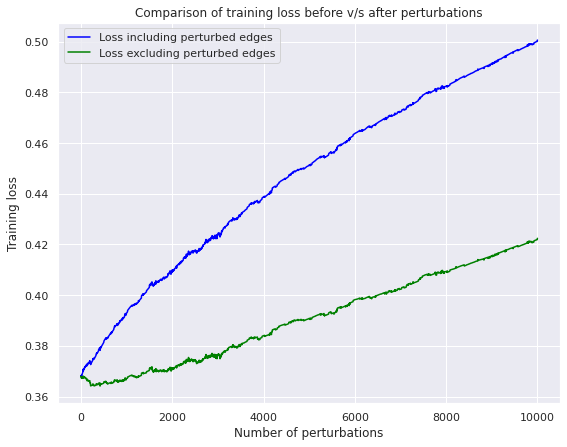

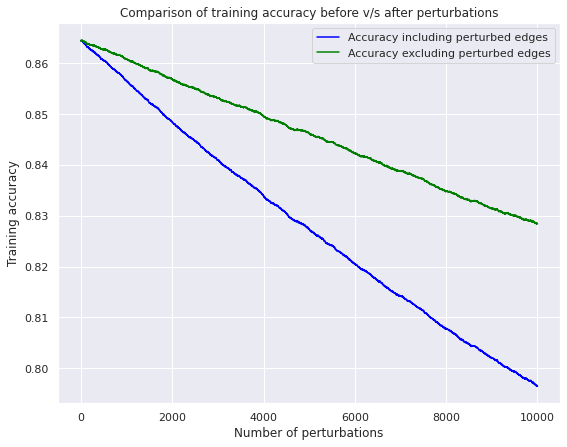

In [9]:
sns.set_theme()
figsize = (9, 7)

# Loss plot

plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss including perturbed edges', color = 'blue').set_title('Comparison of training loss before v/s after perturbations')
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Loss excluding perturbed edges', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Training loss')
plt.legend(labels = ['Loss including perturbed edges', 'Loss excluding perturbed edges'], loc = 'upper left')
fig.savefig('plots/losses_' + filename)
plt.show()

# Accuracy plot
plt.figure(figsize = figsize)
sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy including perturbed edges', color = 'blue').set_title('Comparison of training accuracy before v/s after perturbations')
fig = sns.lineplot(data = perturbations_reset, x = '# Perturbations', y = 'Accuracy excluding perturbed edges', color = 'green').get_figure()
plt.xlabel('Number of perturbations')
plt.ylabel('Training accuracy')
plt.legend(labels = ['Accuracy including perturbed edges', 'Accuracy excluding perturbed edges'])
fig.savefig('plots/accuracy_' + filename)
plt.show()